# Anylsis Pipeline for the project
Team Dog: Maximilian Bernhardt, Patrick Ebner, Simon Enkel, Claudius Hilser, Enno Schwenk

**Content of this notebook:** 
1. Imports
2. Data read-in
3. Defining variables, dataframes and lists
4. Defining functions
5. Data preprocessing & Counting fixations
6. Data Visualization
7. Sanity Checks

### Imports

In [2]:
#Import packages
import numpy as np
import pandas as pd
import os, re
from collections import Counter
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style("white")

### Data read-in
For now, all the filenames get saved in a list. The whole files will be read in with a loop down below.

In [3]:
# Define path for folder with participant data
folder_path = '../data/raw'

# Save all filenames in a list
tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]


### Defining variables, dataframes and lists

In [4]:
# Define target coordinates
target_coords = [
    (-320, 0), (320, 0), (-277, -160), (277, 160), 
    (0, 320), (0, -320), (277, -160), (-277, 160), 
    (-160, -277), (160, 277), (160, -277), (-160, 277)
]
# Define target names according to the coordinates
target_names = [
    'nine', 'three', 'ten', 'four', 
    'six', 'twelve', 'two', 'eight', 
    'eleven', 'five', 'one', 'seven'
]
target_coord_to_name = dict(zip(target_coords, target_names))

# Ensure the dataframe is in the correct order from one to twelve
target_order = [
    'one', 'two', 'three', 'four', 
    'five', 'six', 'seven', 'eight', 
    'nine', 'ten', 'eleven', 'twelve'
]

# Save screen-dimensions and threshold to define whether a target was fixated or not
screen_width = 1920
screen_height = 1080
threshold = 100

# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])

# Define pairs for stimuli belonging together
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five'), ('twelve', 'six')]

# Count all fixations for each participant
fixation_count = []

### Defining Functions
All functions used for the visualizing the results of the research are defined in the following blocks. 

**find_closest_target(row, target_coords, threshold)** \
The first function finds the stimuli which the the fixation lands on. 

**import_coordinates(input_coordinates)** \
This function is used to convert the coordinates logged in OpenSesame in a string into a list which can be used afterwards to calculate whether the fixation was near one of the two stimuli shown. 

**check_event_frequency(df)** \
In this function, all values for the USER-column of the participant data gets counted to gain an overview about all the logged values. This can prove whether each dataset contains all necessary logs to execute the following code for calculating the first fixations.




In [5]:
# Function to find the closest target coordinate within the threshold distance
def find_closest_target(row, target_coords, threshold):
    x, y = row['x_coord'], row['y_coord']
    for tx, ty in target_coords:
        if np.sqrt((x - tx)**2 + (y - ty)**2) <= threshold:
            return (tx, ty)
    return None

# Function to convert the coordinates from a string into a list with numbers
def import_coordinates(input_coordinates):
    pattern = r"-?\d+"
    coordinates_list = []

    # Iterate over all lines of the input
    for i in range(0, len(input_coordinates)):
        # Using regex to find all numbers in the string
        numbers = re.findall(pattern, input_coordinates[i])

        # Convert the extracted number strings to integers
        coordinates = [int(num) for num in numbers]
        coordinates_list.append(coordinates)

    return coordinates_list

# Function to print out all the counts of the logs of the current participant
def check_event_frequency(df):
    # Count the occurrences of each unique value in the 'USER' column
    event_counts = df['USER'].value_counts()
    print("Event frequency in the 'USER' column:")
    print(event_counts)
    print()  # Add a blank line for better readability


### Data Preprocessing & Counting fixations
In the data preprocessing, the data gets prepared for the analysis following in this script. 
At first, the files are read by iterating over the filenames saved above. Afterwards, unnecessary columns get dropped, the time gets normalized to start at 0 and the fixations are extracted. Furthermore, the valid fixations are analyzed for their positions and are added accordingly to the position-number where the participant focussed. \
Finally, the dataframe *sum_df* contains a list with the total number of fixations for every stimuli position (from one to twelve). 

In [6]:
# Initialize an empty dataframe for the sums of fixations
sum_df = pd.DataFrame(columns=['Coordinate', 'Count'])
df_first_fixations = pd.DataFrame()

# Iterate through all .tsv-Files and sum up the fixations for the current file in sum_df
for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'last',
        #'USER': 'first'  # Or another method to handle multiple users
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the coordinates for the current stimuli shown
    df_coordinates_str = df[(df['USER'].str.contains('COORDINATES')) & (df['USER'].notna())]
    df_coordinates_str = df_coordinates_str[['USER', 'TIME']]
    coordinates_list = df_coordinates_str['USER'].to_list()

    coordinates_list = import_coordinates(coordinates_list)

    restructured_list = []
    for item in coordinates_list:
        restructured_list.append((item[0], item[1]))
        restructured_list.append((item[2], item[3]))

    # Initialize a list to store the target coordinates of first fixations
    first_fixation_targets = []

    i = 0

    # Iterate over each 'SHOW_STIMULUS' event time
    for show_time in show_stimulus_times:
        
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]

        target_list = []
        target_list.append(restructured_list[i])
        target_list.append(restructured_list[i+1])
        
        # Find the first fixation within the threshold distance
        for idx, row in valid_fixations.iterrows():
            #target = find_closest_target(row, target_coords, threshold)
            target = find_closest_target(row, target_list, threshold)
            if target:
                first_fixation_targets.append(target)
                break        
        i = i + 2
    
    # Map the target coordinates to their descriptive names
    first_fixation_targets_named = [target_coord_to_name[target] for target in first_fixation_targets]

    # Count the occurrences of each target coordinate name
    target_counts = Counter(first_fixation_targets_named)

    # Convert the counts to a DataFrame for visualization
    target_counts_df = pd.DataFrame(list(target_counts.items()), columns=['Coordinate', 'Count'])

    target_counts_df['Coordinate'] = pd.Categorical(target_counts_df['Coordinate'], categories=target_order, ordered=True)
    target_counts_df = target_counts_df.sort_values('Coordinate')

    # Add number of fixations to the dataframe sum_df which consists of all fixations
    if sum_df.empty:
        sum_df = target_counts_df.copy()
        fixation_count = []
    else:
        sum_df = sum_df.set_index('Coordinate').add(target_counts_df.set_index('Coordinate'), fill_value=0).reset_index()
        
    fixation_count.append(sum(target_counts_df['Count']))  

### Data Visualization
In the following parts, the data gets visualized using different types of plots. Target of these plots is to deal with the topic: "Does diagonal positioning of stimuli eliminate the left-bias in viewing images?​" 


**Count of first fixations** \
The first plot shows, which stimuli position was fixated how often from all participants.

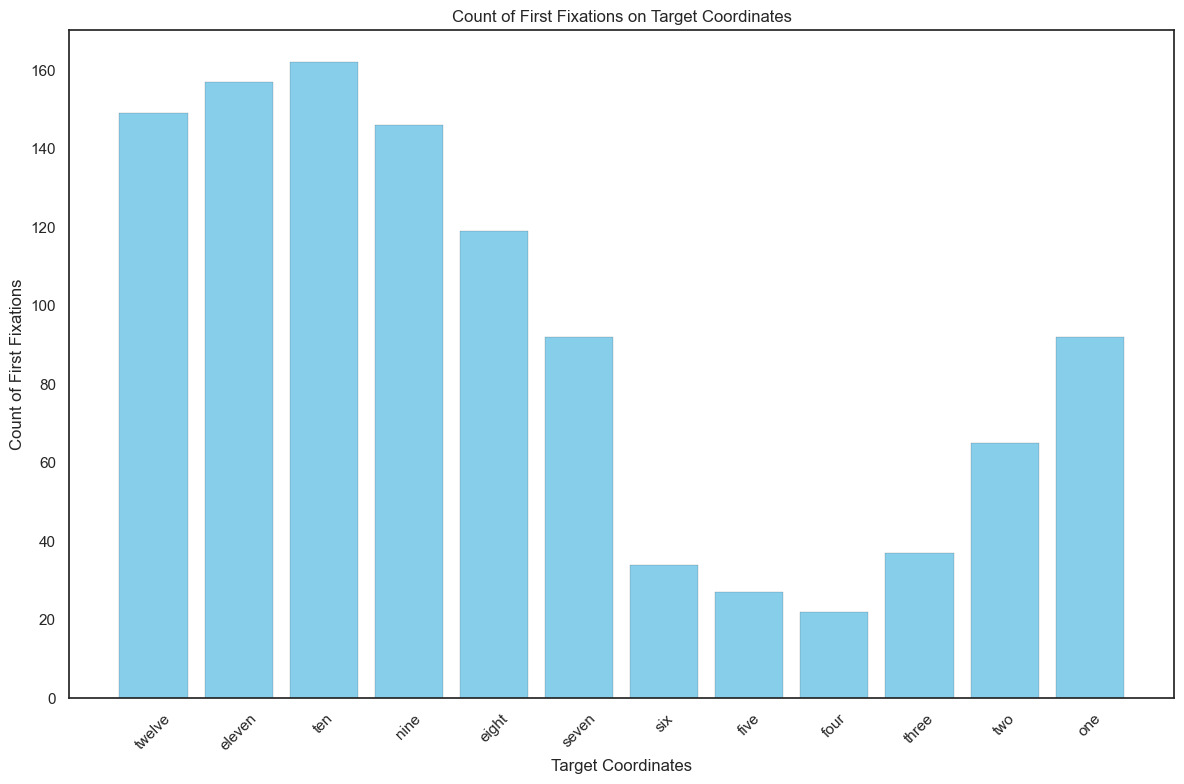

In [7]:
plt.figure(figsize=(12, 8))
reversed_coordinates = sum_df['Coordinate'][::-1]
reversed_count = sum_df['Count'][::-1]
plt.bar(reversed_coordinates, reversed_count, color='skyblue', edgecolor='black', linewidth = 0.1)
plt.xlabel('Target Coordinates')
plt.ylabel('Count of First Fixations')
plt.title('Count of First Fixations on Target Coordinates')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

**Clock-wise layout of results** \
In the second visual, the amount of fixations for each position are visualized clock-wise to get a better overview about whether there is a tendency to the left or to the right.

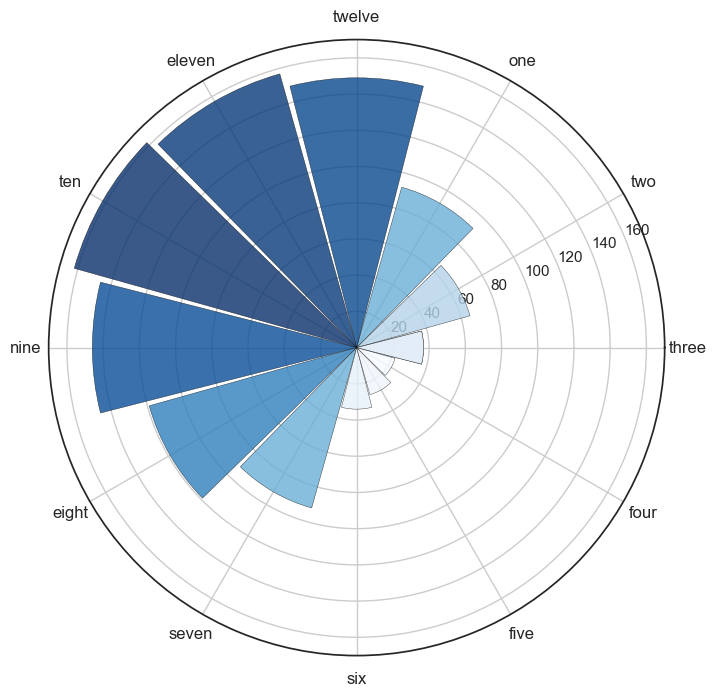

In [8]:
# Die Kategorien in der gewünschten Reihenfolge umsortieren
categories = ['three', 'two', 'one','twelve', 'eleven', 'ten', 'nine', 'eight', 'seven', 'six', 'five', 'four']

# Die Werte in der Reihenfolge der Kategorien anordnen
values = sum_df.set_index('Coordinate').reindex(categories)['Count'].fillna(0).values

# Anzahl der Kategorien
num_vars = len(categories)

# Winkel für jedes Segment berechnen
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Werte für den geschlossenen Radialplot erweitern
values = np.concatenate((values,[values[0]]))
angles += angles[:1]

# Colormap definieren (eine Farbe mit unterschiedlichen Intensitäten)
cmap = plt.cm.Blues  # Blau als Basisfarbe
norm = Normalize(vmin=min(values), vmax=max(values))
colors = cmap(norm(values))

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Balken für jedes Segment erstellen
bars = ax.bar(angles, values, width=0.5, color=colors, edgecolor='black', linewidth=0.3, alpha=0.8)

# Kategorien als Beschriftungen setzen
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, ha='center')

plt.show()

**Percentual comparison for the different stimuli pairs** \
To gain another insight to the left-/right-distribution, the ratio for each stimuli pair is calculated and shown in bars from 0 to 100 percent. 

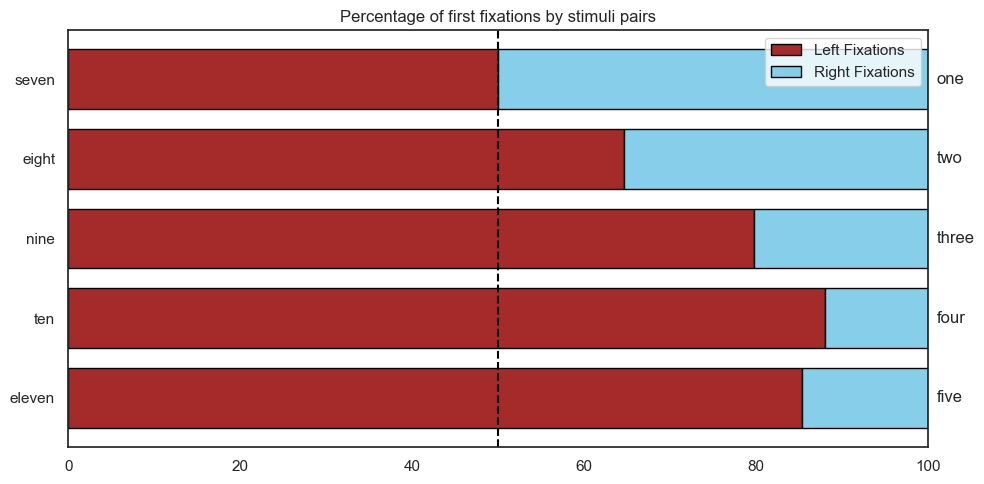

In [9]:
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five')]

# Calculte the sum for each pair
pair_sums = []
for coord1, coord2 in pairs:
    count1 = sum_df[sum_df['Coordinate'] == coord1]['Count'].values[0]
    count2 = sum_df[sum_df['Coordinate'] == coord2]['Count'].values[0]
    total = count1 + count2
    pair_sums.append((coord1, coord2, count1 / total, count2 / total))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Reverse the order of the pairs
pair_sums = pair_sums[::-1]

# Prepare values for the diagram
left_description = [f'{pairs[4-i][0]}' for i in range(0, len(pair_sums))]
right_description = [f'{pairs[4-i][1]}' for i in range(0, len(pair_sums))]
left_fixations = [left for _, _, left, _ in pair_sums]
right_fixations = [right for _, _, _, right in pair_sums]

# Upgrade values to percent
left_fixations = [i * 100 for i in left_fixations]
right_fixations = [i * 100 for i in right_fixations]

# Create plot
bar_width = 0.75
y = np.arange(len(left_description))

# Create left and right bars
ax.barh(y, left_fixations, color='brown', height=bar_width, edgecolor='black', label='Left Fixations')
ax.barh(y, right_fixations, left=left_fixations, color='skyblue', height=bar_width, edgecolor='black', label='Right Fixations')

# Add center line
ax.axvline(50, color='black', linestyle='--')

# Define labels and titel
ax.set_yticks(y)
ax.set_yticklabels(left_description)
#ax.set_xlabel('Percentage of first fixations to the left | right')
ax.set_title('Percentage of first fixations by stimuli pairs')
ax.legend()

# Add right side labels
for i in range(len(y)):
    ax.text(101, y[i], right_description[i], va='center')

# Adjust x-axis from 0 to 100
ax.set_xlim(0, 100)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

**Pairwise comparison of stimuli pairs** \
Finally, there is another comparison of the stimuli pairs dealing with total numbers this time.

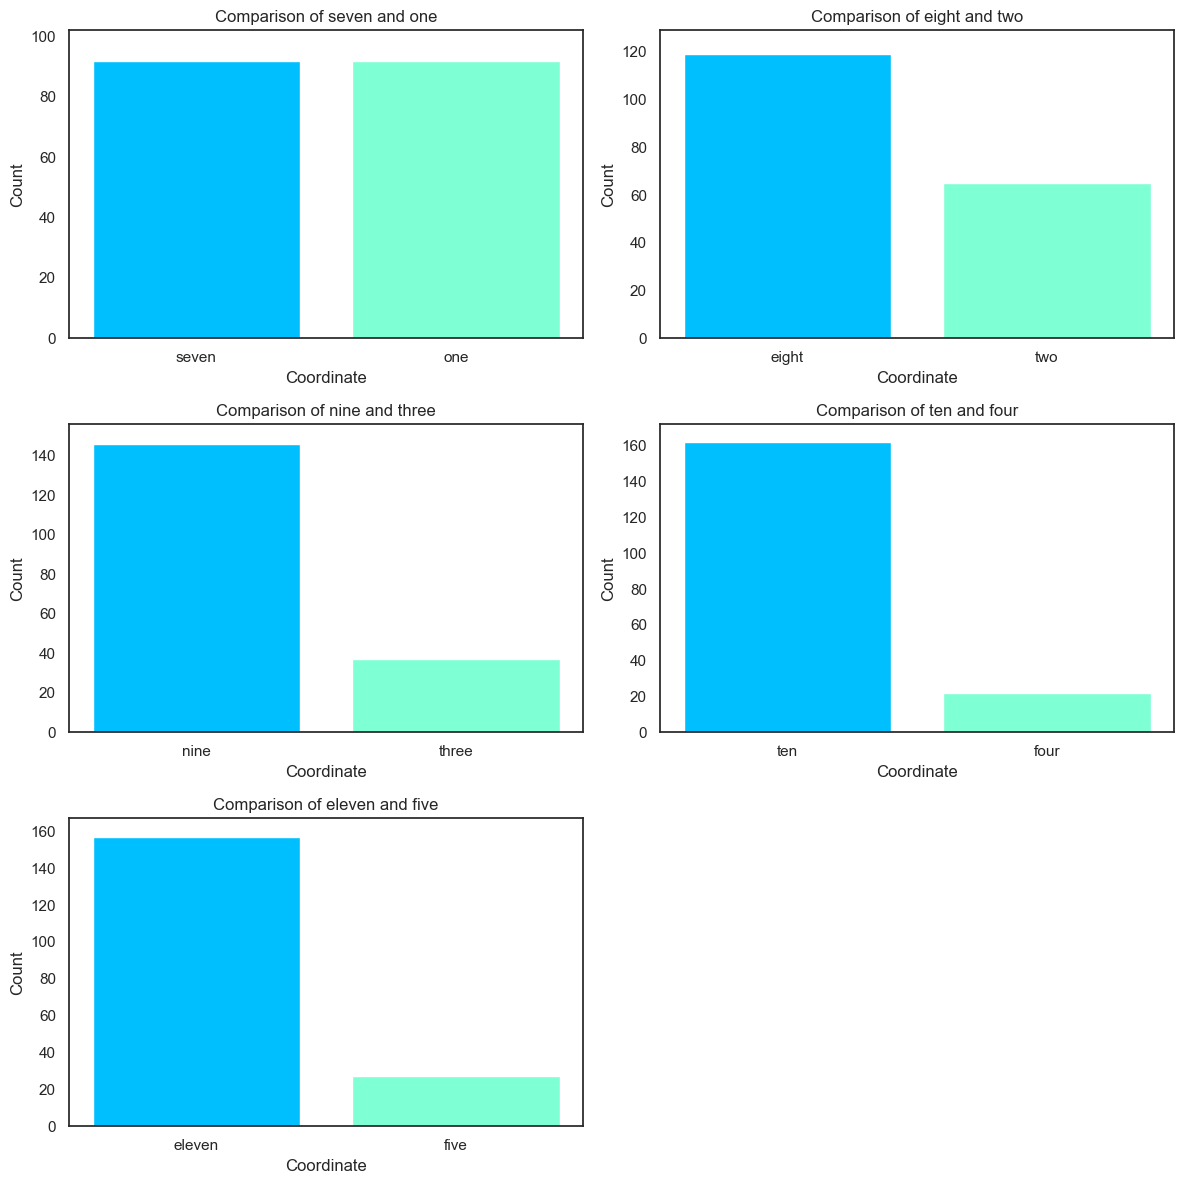

In [10]:
# Create a figure with 5 subplots in a 3x2 grid, but only use 5
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over the first five pairs
for i, pair in enumerate(pairs[:5]):
    coord1, coord2 = pair
    
    # Select data for the current pair
    data1 = sum_df[sum_df['Coordinate'] == coord1]['Count']
    data2 = sum_df[sum_df['Coordinate'] == coord2]['Count']
    
    # Ensure data is available
    if len(data1) == 0 or len(data2) == 0:
        continue
    
    # Define positions for bars on the x-axis
    x = [1, 2]

    # Define height
    height1 = data1.values[0]
    height2 = data2.values[0]

    # Define labels for the x-axis
    labels = [coord1, coord2]

    # Define colors for the bars
    bar_colors = ['#00BFFF', '#7FFFD4']

    # Create histogram and define titles and axis-limits
    axs[i].bar(x, [height1, height2], tick_label=labels, color=bar_colors)
    axs[i].set_title(f'Comparison of {coord1} and {coord2}')
    axs[i].set_xlabel('Coordinate')
    axs[i].set_ylabel('Count')
    axs[i].set_ylim(0, max(height1, height2) + 10)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Optimize layout and show plots
plt.tight_layout()
plt.show()


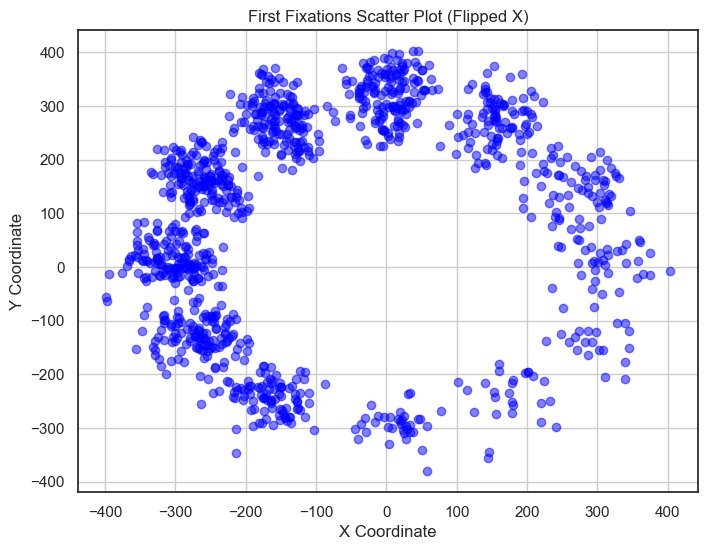

In [11]:

# Initialize a list to store the coordinates of first fixations
first_fixation_coords = []

# Iterate through all .tsv-Files and process the data
for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'last',
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the coordinates for the current stimuli shown
    df_coordinates_str = df[(df['USER'].str.contains('COORDINATES')) & (df['USER'].notna())]
    df_coordinates_str = df_coordinates_str[['USER', 'TIME']]
    coordinates_list = df_coordinates_str['USER'].to_list()

    coordinates_list = import_coordinates(coordinates_list)

    restructured_list = []
    for item in coordinates_list:
        restructured_list.append((item[0], item[1]))
        restructured_list.append((item[2], item[3]))

    # Initialize a list to store the target coordinates of first fixations
    first_fixation_targets = []

    i = 0

    # Iterate over each 'SHOW_STIMULUS' event time
    for show_time in show_stimulus_times:
        
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]

        target_list = []
        target_list.append(restructured_list[i])
        target_list.append(restructured_list[i+1])
        
        # Find the first fixation within the threshold distance
        for idx, row in valid_fixations.iterrows():
            target = find_closest_target(row, target_list, threshold)
            if target:
                first_fixation_targets.append(target)
                first_fixation_coords.append((row['x_coord'], row['y_coord']))  # Store the coordinates
                break        
        i = i + 2

# Convert first fixation coordinates to a DataFrame
first_fixation_coords = pd.DataFrame(first_fixation_coords, columns=['x', 'y'])

# Flip the x-coordinates by negating them
first_fixation_coords['y'] = -first_fixation_coords['y']

# Create a scatter plot of all first fixations
plt.figure(figsize=(8, 6))
plt.scatter(first_fixation_coords['x'], first_fixation_coords['y'], c='blue', alpha=0.5)
plt.title('First Fixations Scatter Plot (Flipped X)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()


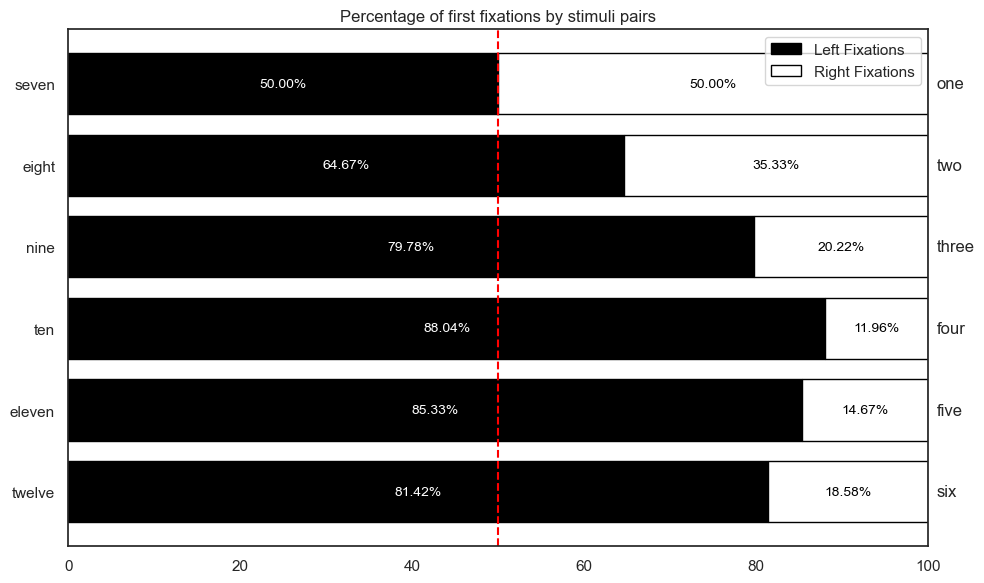

In [12]:
# Add the sixth pair to the list
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), ('eleven', 'five'), ('twelve', 'six')]

# Calculate the sum for each pair
pair_sums = []
for coord1, coord2 in pairs:
    count1 = sum_df[sum_df['Coordinate'] == coord1]['Count'].values[0]
    count2 = sum_df[sum_df['Coordinate'] == coord2]['Count'].values[0]
    total = count1 + count2
    pair_sums.append((coord1, coord2, count1 / total, count2 / total))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted the figure size to accommodate the extra pair

# Reverse the order of the pairs
pair_sums = pair_sums[::-1]

# Prepare values for the diagram
left_description = [f'{pairs[5-i][0]}' for i in range(0, len(pair_sums))]
right_description = [f'{pairs[5-i][1]}' for i in range(0, len(pair_sums))]
left_fixations = [left for _, _, left, _ in pair_sums]
right_fixations = [right for _, _, _, right in pair_sums]

# Upgrade values to percent
left_fixations = [i * 100 for i in left_fixations]
right_fixations = [i * 100 for i in right_fixations]

# Create plot
bar_width = 0.75
y = np.arange(len(left_description))

# Create left and right bars
ax.barh(y, left_fixations, color='black', height=bar_width, edgecolor='black', label='Left Fixations')
ax.barh(y, right_fixations, left=left_fixations, color='white', height=bar_width, edgecolor='black', label='Right Fixations')

# Add center line
ax.axvline(50, color='red', linestyle='--')

# Define labels and title
ax.set_yticks(y)
ax.set_yticklabels(left_description)
ax.set_title('Percentage of first fixations by stimuli pairs')
ax.legend()

# Add right side labels
for i in range(len(y)):
    ax.text(101, y[i], right_description[i], va='center')

# Add percentages inside the bars
for i in range(len(pair_sums)):
    # Place the left percentage inside the left bar
    ax.text(left_fixations[i] / 2, y[i], f'{left_fixations[i]:.2f}%', va='center', ha='center', fontsize=10, color='white')
    # Place the right percentage inside the right bar
    ax.text(left_fixations[i] + right_fixations[i] / 2, y[i], f'{right_fixations[i]:.2f}%', va='center', ha='center', fontsize=10, color='black')

# Adjust x-axis from 0 to 100
ax.set_xlim(0, 100)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


### Sanity Checks
Testing the used data for some possible problems. In the current case, the last example from the loop above is used by taking the data from *df*. To see the event frequency for all participant, include the method *check_balancing_erros* into the loop.

**Count extracted fixations** \
Inside the loop, the fixations for each participants are counted and printed out here. As visible, beside one run, for every other one 48 fixations were counted for the 48 stimuli pairs.

In [13]:
# Checking how many fixations were counted for every participant
print(fixation_count)

[48, 47, 48, 48, 48, 48, 48, 48, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]


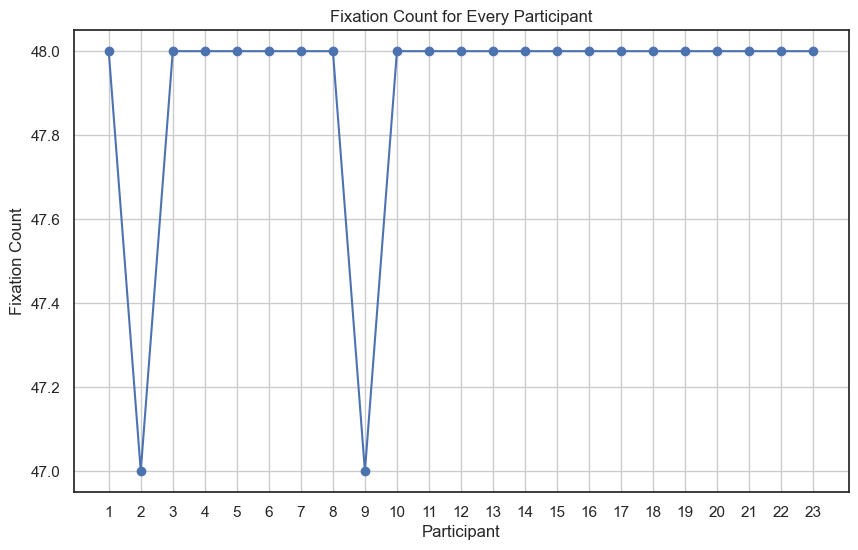

In [14]:
# Plotting the fixation count for every participant
plt.figure(figsize=(10, 6))
plt.plot(fixation_count, marker='o', linestyle='-', color='b')
plt.title('Fixation Count for Every Participant')
plt.xlabel('Participant')
plt.ylabel('Fixation Count')
plt.grid(True)
plt.xticks(range(len(fixation_count)), range(1, len(fixation_count) + 1))
plt.show()

**Appearence of stimuli pairs** \
The check shows the distribution of the shown pairs. As visible, one fixation for the pair three/six could not be detected, but overall the pairs are balanced.

In [15]:
# Checking how often every stimuli pair occured
opposite_sums = []
total_sum = 0
expected_sum = len(tsv_files)*48

opposite_sums.append(sum_df[sum_df['Coordinate'] == 'one']['Count'].values + sum_df[sum_df['Coordinate'] == 'seven']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'two']['Count'].values + sum_df[sum_df['Coordinate'] == 'eight']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'three']['Count'].values + sum_df[sum_df['Coordinate'] == 'nine']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'four']['Count'].values + sum_df[sum_df['Coordinate'] == 'ten']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'five']['Count'].values + sum_df[sum_df['Coordinate'] == 'eleven']['Count'])
opposite_sums.append(sum_df[sum_df['Coordinate'] == 'six']['Count'].values + sum_df[sum_df['Coordinate'] == 'twelve']['Count'])

for i in range(0, 6):
    print(i+1, sum(opposite_sums[i]), sep=': ')
    total_sum = total_sum + sum(opposite_sums[i])

print('Total sum: ', total_sum)
print('Expected sum: ', expected_sum)

1: 184.0
2: 184.0
3: 183.0
4: 184.0
5: 184.0
6: 183.0
Total sum:  1102.0
Expected sum:  1104


Flattened opposite_sums: [184.0, 184.0, 183.0, 184.0, 184.0, 183.0]


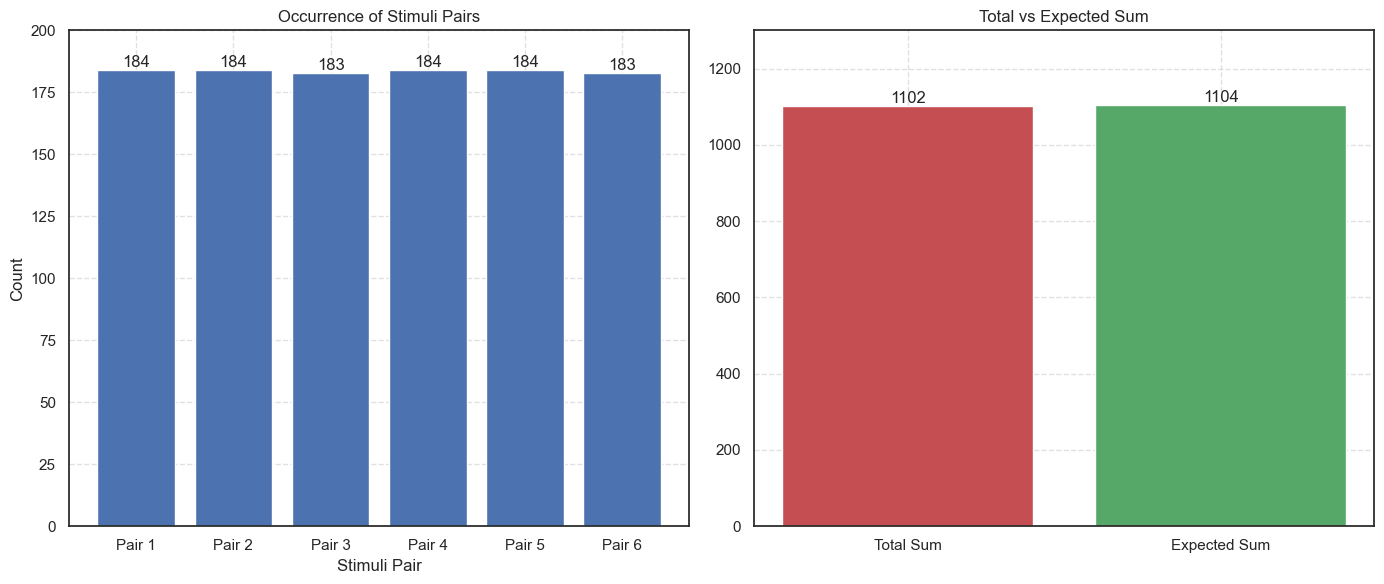

In [16]:
# Ensure opposite_sums is a flat list of numerical values
opposite_sums = [x.iloc[0] if isinstance(x, pd.Series) else x for x in opposite_sums]

# Debug print to check the values of opposite_sums after flattening
print("Flattened opposite_sums:", opposite_sums)

# Plotting the bar chart for each stimuli pair
plt.figure(figsize=(14, 6))

# Plot for Occurrence of Stimuli Pairs
plt.subplot(1, 2, 1)
pairs = ['Pair 1', 'Pair 2', 'Pair 3', 'Pair 4', 'Pair 5', 'Pair 6']
bars = plt.bar(pairs, opposite_sums, color='b')
plt.title('Occurrence of Stimuli Pairs')
plt.xlabel('Stimuli Pair')
plt.ylabel('Count')
plt.ylim(0, 200)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom')  # va: vertical alignment

# Plot for Total and Expected Sums
plt.subplot(1, 2, 2)
bars = plt.bar(['Total Sum', 'Expected Sum'], [total_sum, expected_sum], color=['r', 'g'])
plt.title('Total vs Expected Sum')
plt.ylim(0, 1300)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom')  # va: vertical alignment

# Adjust layout
plt.tight_layout()
plt.show()

**Show logging output** \
At first, the output from the logging in OpenSesame is shown and can be checked for completeness.

In [17]:
# df is the dataframe for the last participant
check_event_frequency(df)

Event frequency in the 'USER' column:
USER
SHOW_STIMULUS                        48
HIDE_STIMULUS                        43
START_SEQUENCE                       40
STOP_SEQUENCE                        39
COORDINATES:(-160,-277, 160, 277)     4
COORDINATES:(-277,-160, 277, 160)     4
COORDINATES:(-160,277, 160, -277)     4
COORDINATES:(277,160, -277, -160)     4
COORDINATES:(-277,160, 277, -160)     4
COORDINATES:(0,-320, 0, 320)          4
COORDINATES:(160,277, -160, -277)     4
COORDINATES:(320,0, -320, 0)          4
COORDINATES:(160,-277, -160, 277)     4
COORDINATES:(0,320, 0, -320)          4
COORDINATES:(-320,0, 320, 0)          4
COORDINATES:(277,-160, -277, 160)     4
STIMULI: (009.PNG, 014.PNG)           3
STIMULI: (000.PNG, 016.PNG)           2
STIMULI: (001.PNG, 019.PNG)           2
STIMULI: (008.PNG, 005.PNG)           2
STIMULI: (021.PNG, 009.PNG)           2
STIMULI: (010.PNG, 002.PNG)           2
STIMULI: (015.PNG, 015.PNG)           2
STIMULI: (017.PNG, 010.PNG)          

**Appearence of logs** \
The last check shows the count of the logs. As visible, some logs were lost, but only the ones not used for our results.

In [18]:
# Initialize an empty DataFrame to accumulate all data
all_data_df = pd.DataFrame()  

# Iterate through all .tsv-Files and sum up the fixations for the current file in sum_df
for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]
    
    # Accumulate the data frame
    all_data_df = pd.concat([all_data_df, df], ignore_index=True)

# After the loop, check balancing errors on the accumulated data frame
check_event_frequency(all_data_df)


Event frequency in the 'USER' column:
USER
SHOW_STIMULUS                        1104
HIDE_STIMULUS                        1104
START_SEQUENCE                       1103
STOP_SEQUENCE                        1099
COORDINATES:(277,160, -277, -160)      92
                                     ... 
STIMULI: (016.PNG, 007.PNG)             2
STIMULI: (014.PNG, 012.PNG)             2
STIMULI: (001.PNG, 020.PNG)             2
STIMULI: (000.PNG, 002.PNG)             2
STIMULI: (001.PNG, 019.PNG)             2
Name: count, Length: 326, dtype: int64



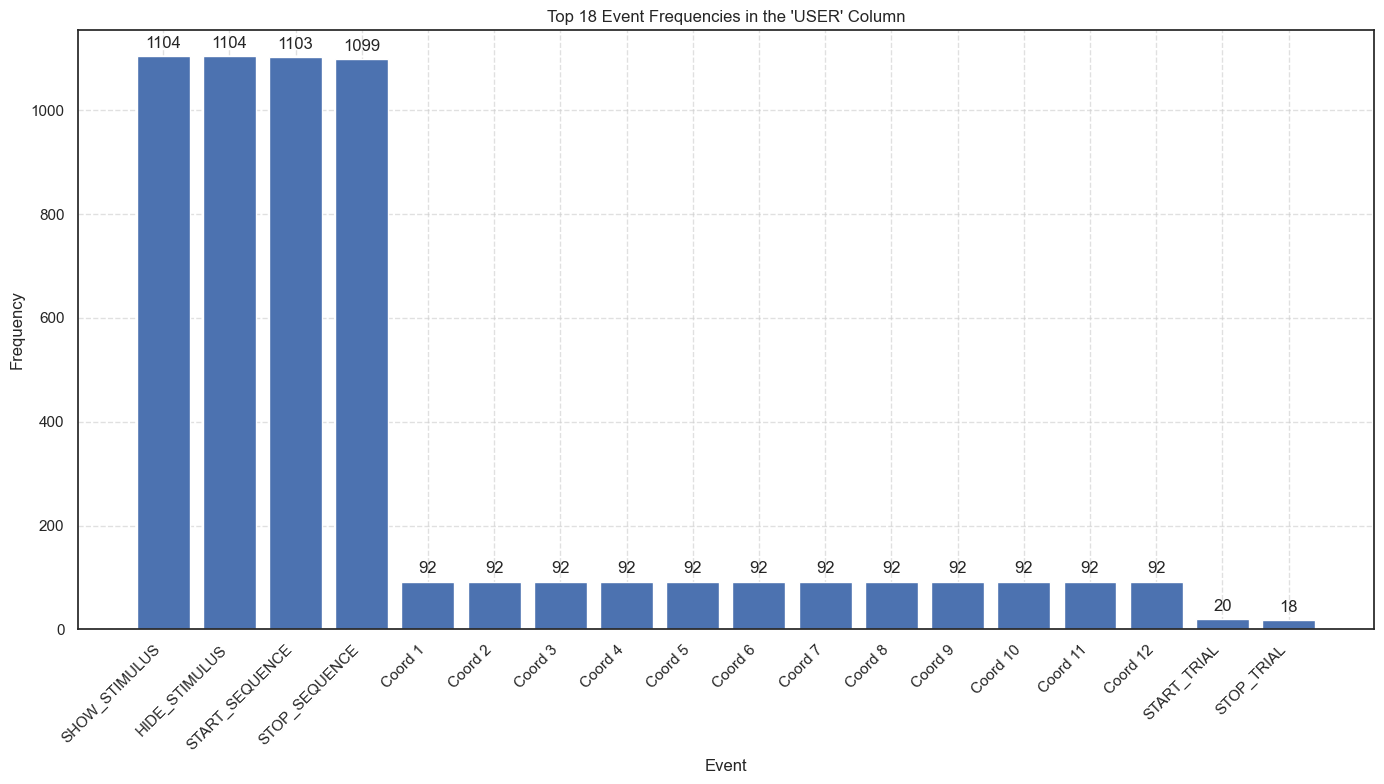

In [19]:
# Count the occurrences of each event in the 'USER' column
event_counts = all_data_df['USER'].value_counts()

# Select the top 20 most frequent events
top_events = event_counts.head(18)

# Convert to DataFrame for ease of plotting
df_event_counts = top_events.reset_index()
df_event_counts.columns = ['USER', 'Count']

# Replace 'COORDINATES' log names with 'Coord 1', 'Coord 2', ..., 'Coord 6'
coord_counter = 1
for i, user in enumerate(df_event_counts['USER']):
    if 'COORDINATES' in user:
        df_event_counts.at[i, 'USER'] = f'Coord {coord_counter}'
        coord_counter += 1

# Plotting the event frequency
plt.figure(figsize=(14, 8))

bars = plt.bar(df_event_counts['USER'], df_event_counts['Count'], color='b')
plt.title("Top 18 Event Frequencies in the 'USER' Column")
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, df_event_counts['Count'].max() + 50)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 10, int(yval), ha='center', va='bottom')  # va: vertical alignment

plt.tight_layout()
plt.show()

### Data Frame for Individual Participants

In [20]:
import os
import pandas as pd
import numpy as np

# Define a function to find the closest target
def find_closest_target(row, target_list, threshold):
    x, y = row['x_coord'], row['y_coord']
    for target in target_list:
        distance = np.sqrt((x - target[0])**2 + (y - target[1])**2)
        if distance <= threshold:
            return target
    return None

# Define a function to assign groups based on the closest target coordinates
def assign_group(x, y, target_coords, target_names):
    distances = [np.sqrt((x - tx)**2 + (y - ty)**2) for tx, ty in target_coords]
    closest_index = np.argmin(distances)
    return target_names[closest_index]

# Initialize an empty DataFrame to store the first fixation data
tidy_df = pd.DataFrame(columns=['subject', 'condition', 'reaction_time', 'first_fixation', 'choice'])

# Define pairs for stimuli belonging together
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), ('ten', 'four'), 
         ('eleven', 'five'), ('twelve', 'six')]

# Map pairs to their corresponding coordinates
pair_coord_to_name = {
    ('seven', 'one'): [(-160,-277), (160, 277)],
    ('eight', 'two'): [(-277, -160), (277, 160)],
    ('nine', 'three'): [(-320, 0), (320, 0)],
    ('ten', 'four'): [(277, -160), (-277, 160)],
    ('eleven', 'five'): [(-160, 277), (160, -277)],
    ('twelve', 'six'): [(0,320), (0,-320)]
}

# Iterate through all .tsv files
for file in tsv_files:
    # Extract subject ID from filename (assume numeric portion identifies the subject)
    subject_id = int(re.search(r'\d+', file).group()) if re.search(r'\d+', file) else "Unknown"

    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'last'
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the coordinates for the current stimuli shown
    df_coordinates_str = df[(df['USER'].str.contains('COORDINATES')) & (df['USER'].notna())]
    df_coordinates_str = df_coordinates_str[['USER', 'TIME']]
    coordinates_list = df_coordinates_str['USER'].to_list()

    coordinates_list = import_coordinates(coordinates_list)

    restructured_list = []
    for item in coordinates_list:
        restructured_list.append((item[0], item[1]))
        restructured_list.append((item[2], item[3]))

    # Iterate over each 'SHOW_STIMULUS' event time
    i = 0
    for show_time in show_stimulus_times:
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]

        # Define trial targets (pair of coordinates)
        target_list = [restructured_list[i], restructured_list[i+1]]
        i += 2

        # Find the first fixation within the target pair coordinates
        for idx, row in valid_fixations.iterrows():
            target = find_closest_target(row, target_list, threshold)
            if target:
                reaction_time = row['TIME'] - show_time
                
                # Find the corresponding pair name
                for pair_name, pair_coords in pair_coord_to_name.items():
                    if target in pair_coords:
                        condition = '-'.join(pair_name)
                        # Determine which target was chosen
                        first_fixation = pair_name[0] if target == pair_coords[0] else pair_name[1]
                        # Determine the choice (0 for first stimulus, 1 for second stimulus)
                        choice = 0 if target == pair_coords[0] else 1
                        break

                tidy_df = pd.concat([tidy_df, pd.DataFrame({
                    'subject': [subject_id],
                    'condition': [condition],
                    'reaction_time': [reaction_time],
                    'first_fixation': [first_fixation],
                    'choice': [choice]
                })], ignore_index=True)
                break

# Calculate the mean choice for each participant by condition
mean_choice_by_subject_condition = tidy_df.groupby(['subject', 'condition'])['choice'].mean().reset_index()
mean_choice_by_subject_condition.rename(columns={'choice': 'mean_choice_by_condition'}, inplace=True)

# Merge the mean choice by condition back into the tidy_df
tidy_df = pd.merge(tidy_df, mean_choice_by_subject_condition, on=['subject', 'condition'], how='left')

# Save the tidy DataFrame to a CSV file
tidy_df.to_csv('tidy_data.csv', index=False)
print(tidy_df.head())

/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/429171785.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tidy_df = pd.concat([tidy_df, pd.DataFrame({


  subject    condition  reaction_time first_fixation choice  \
0      17   nine-three        0.79236           nine      0   
1      17   nine-three        1.18063           nine      0   
2      17   twelve-six        0.84140            six      1   
3      17  eleven-five        0.66323           five      1   
4      17    eight-two        0.66293          eight      0   

  mean_choice_by_condition  
0                    0.375  
1                    0.375  
2                      1.0  
3                      1.0  
4                      0.0  


In [21]:
!pip install pandas numpy matplotlib seaborn 
!pip install plotnine


In [22]:
import os
import pandas as pd
from plotnine import *
import numpy as np

# Define a function to assign groups based on the closest target coordinates
def assign_group(x, y, target_coords, target_names):
    distances = [np.sqrt((x - tx)**2 + (y - ty)**2) for tx, ty in target_coords]
    closest_index = np.argmin(distances)
    return target_names[closest_index]

# Update the processing logic to include group assignment
all_first_fixations = []

for file in tsv_files:
    # Load the file
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep='\t')

    # Drop unnecessary columns
    df = df[['CNT', 'TIME', 'FPOGX', 'FPOGY', 'FPOGS', 'FPOGD', 'FPOGID', 'FPOGV', 'BPOGX', 'BPOGY', 'BPOGV', 'USER']]

    # Normalize the time for the current file to begin at zero
    df['TIME'] = df['TIME'] - df['TIME'].iloc[0]

    # Filter for valid points
    df = df[(df['FPOGV'] == 1) | (df['USER'] == 'SHOW_STIMULUS') | (df['USER'].str.contains('COORDINATES'))]

    # Create a new dataframe to save all fixations
    df_fixations = df.groupby('FPOGID').agg({
        'FPOGX': 'last',
        'FPOGY': 'last',
        'TIME': 'last',
    }).reset_index()

    df_fixations['x_coord'] = (df_fixations['FPOGX'] - 0.5) * screen_width
    df_fixations['y_coord'] = (df_fixations['FPOGY'] - 0.5) * screen_height

    # Find the indices of 'SHOW_STIMULUS' events
    show_stimulus_times = df[df['USER'] == 'SHOW_STIMULUS']['TIME'].values

    # Get the coordinates for the current stimuli shown
    df_coordinates_str = df[(df['USER'].str.contains('COORDINATES')) & (df['USER'].notna())]
    df_coordinates_str = df_coordinates_str[['USER', 'TIME']]
    coordinates_list = df_coordinates_str['USER'].to_list()

    coordinates_list = import_coordinates(coordinates_list)

    restructured_list = []
    for item in coordinates_list:
        restructured_list.append((item[0], item[1]))
        restructured_list.append((item[2], item[3]))

    # Initialize a list to store the target coordinates of first fixations
    i = 0

    # Iterate over each 'SHOW_STIMULUS' event time
    for show_time in show_stimulus_times:
        # Filter fixations that occur after the 'SHOW_STIMULUS' event time
        valid_fixations = df_fixations[df_fixations['TIME'] > show_time]

        target_list = []
        target_list.append(restructured_list[i])
        target_list.append(restructured_list[i + 1])

        # Find the first fixation within the threshold distance
        for idx, row in valid_fixations.iterrows():
            target = find_closest_target(row, target_list, threshold)
            if target:
                all_first_fixations.append({
                    'file': file,
                    'x_coord': row['x_coord'],
                    'y_coord': row['y_coord'],
                    'target': target
                })
                break
        i = i + 2

# Convert all_first_fixations to a DataFrame
first_fixations_df = pd.DataFrame(all_first_fixations)

# Assign groups based on the closest target
first_fixations_df['group'] = first_fixations_df.apply(
    lambda row: assign_group(row['x_coord'], row['y_coord'], target_coords, target_names), axis=1
)

# first_fixations_df['combined'] = first_fixations_df['x_coord'].astype(str) + '-' + first_fixations_df['y_coord'].astype(str)

# Define the pairs
pairs = [('seven', 'one'), ('eight', 'two'), ('nine', 'three'), 
         ('ten', 'four'), ('eleven', 'five'), ('twelve', 'six')]

# Create a dictionary to map each group to its pair
pair_dict = {group1: group2 for group1, group2 in pairs}
pair_dict.update({group2: group1 for group1, group2 in pairs})

# Add a combined pair column to the DataFrame
first_fixations_df['combined_pair'] = first_fixations_df['group'].map(pair_dict)
first_fixations_df['combined_pair'] = first_fixations_df.apply(
    lambda row: '-'.join(sorted([row['group'], row['combined_pair']])), axis=1
)

# Drop the individual pair column if it's no longer needed
first_fixations_df.drop(columns=['pair'], errors='ignore', inplace=True)

# Updated plot to include combined pairs
plot = (
    ggplot(first_fixations_df, aes(x='combined_pair', y='y_coord')) +
    geom_sina() +
    labs(title='Distribution of First Fixations by Combined Pairs', x='Combined Pair', y='Y Coordinates') +
    scale_x_discrete(limits=[
        'one-seven', 'two-eight', 'three-nine', 
        'four-ten', 'five-eleven', 'six-twelve'
    ]) +  # Replace with your desired order
    theme_minimal()
)

# Save the updated plot
plot.save("first_fixations_plot_combined_pairs.png")



/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/anaconda3/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: first_fixations_plot_combined_pairs.png
/opt/anaconda3/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_sina : Removed 549 rows containing non-finite values.


/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/83794774.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/83794774.py:21: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).



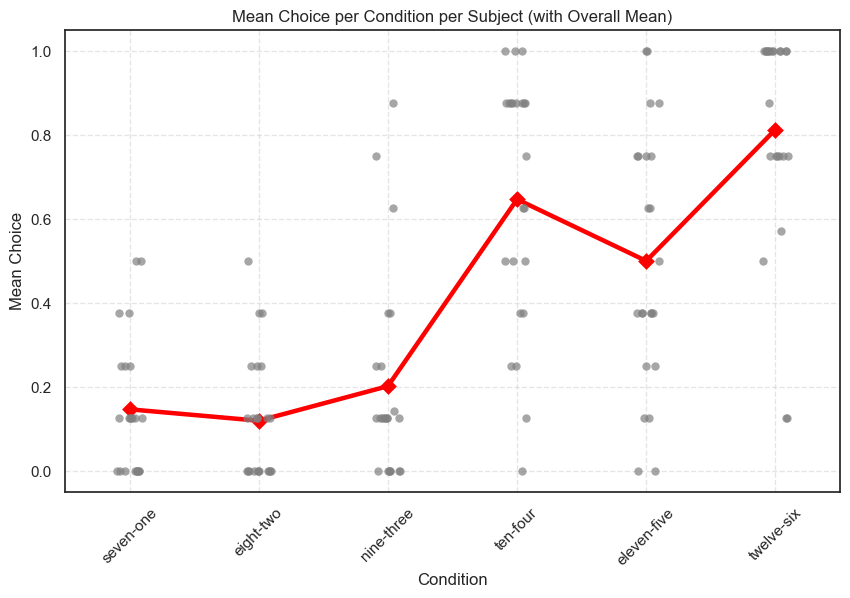

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order for the conditions
condition_order = ['seven-one', 'eight-two', 'nine-three', 'ten-four', 'eleven-five', 'twelve-six']

# Create the figure
plt.figure(figsize=(10, 6))

# Plot individual participant means as jittered dots
sns.stripplot(data=mean_choice_by_subject_condition, 
              x='condition', 
              y='mean_choice_by_condition', 
              order=condition_order,  # Apply the custom order
              jitter=True, 
              alpha=0.7, 
              color='gray', 
              size=6)

# Plot overall mean for each condition
sns.pointplot(data=mean_choice_by_subject_condition, 
              x='condition', 
              y='mean_choice_by_condition', 
              order=condition_order,  # Apply the custom order
              estimator='mean', 
              ci=None, 
              color='red', 
              markers='D', 
              scale=1.2)

# Customize the plot
plt.xlabel('Condition')
plt.ylabel('Mean Choice')
plt.title('Mean Choice per Condition per Subject (with Overall Mean)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()


/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/2916412917.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/2916412917.py:29: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).



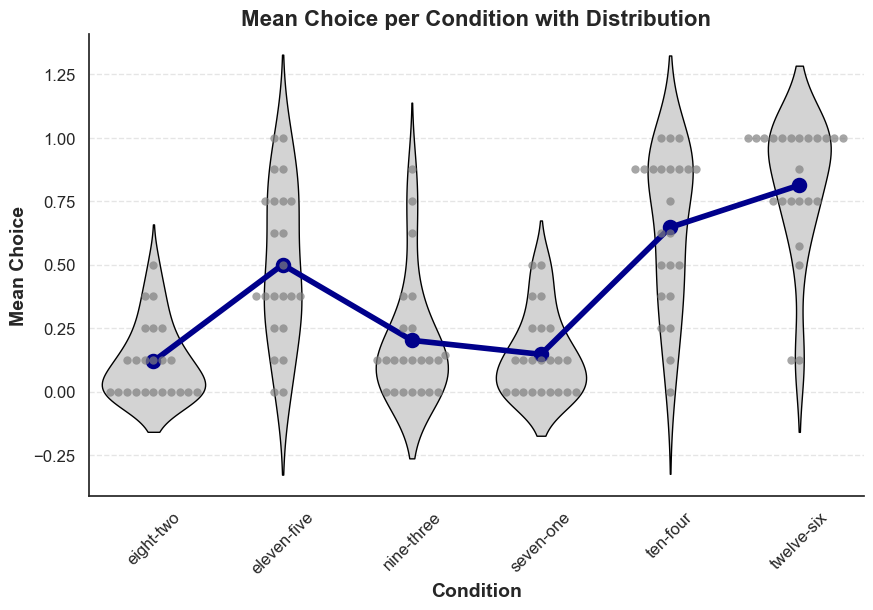

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order for the conditions based on the dataframe
condition_order = sorted(tidy_df['condition'].unique(), key=lambda x: [int(s) if s.isdigit() else s for s in x.split('-')])

# Create the figure
plt.figure(figsize=(10, 6))

# Violinplot to show data distribution
sns.violinplot(data=mean_choice_by_subject_condition, 
               x='condition', 
               y='mean_choice_by_condition', 
               order=condition_order, 
               inner=None, 
               color='lightgray', 
               linewidth=1)

# Swarmplot to show individual data points
sns.swarmplot(data=mean_choice_by_subject_condition, 
              x='condition', 
              y='mean_choice_by_condition', 
              order=condition_order, 
              color='gray', 
              size=6, 
              alpha=0.7)

# Pointplot for mean values with a more neutral color scheme
sns.pointplot(data=mean_choice_by_subject_condition, 
              x='condition', 
              y='mean_choice_by_condition', 
              order=condition_order, 
              estimator='mean', 
              ci=None, 
              color='darkblue', 
              markers='o', 
              scale=1.5, 
              linewidth=1.5)

# Manuelles Anpassen der Marker-Ränder
for artist in plt.gca().collections:
    artist.set_edgecolor('black')

# Customize the plot for scientific presentation
plt.xlabel('Condition', fontsize=14, fontweight='bold')
plt.ylabel('Mean Choice', fontsize=14, fontweight='bold')
plt.title('Mean Choice per Condition with Distribution', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()

# Show the plot
plt.show()


/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/762387402.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

/var/folders/l1/l7hvgfwx0ylghyx62gbylzxc0000gn/T/ipykernel_6075/762387402.py:29: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).



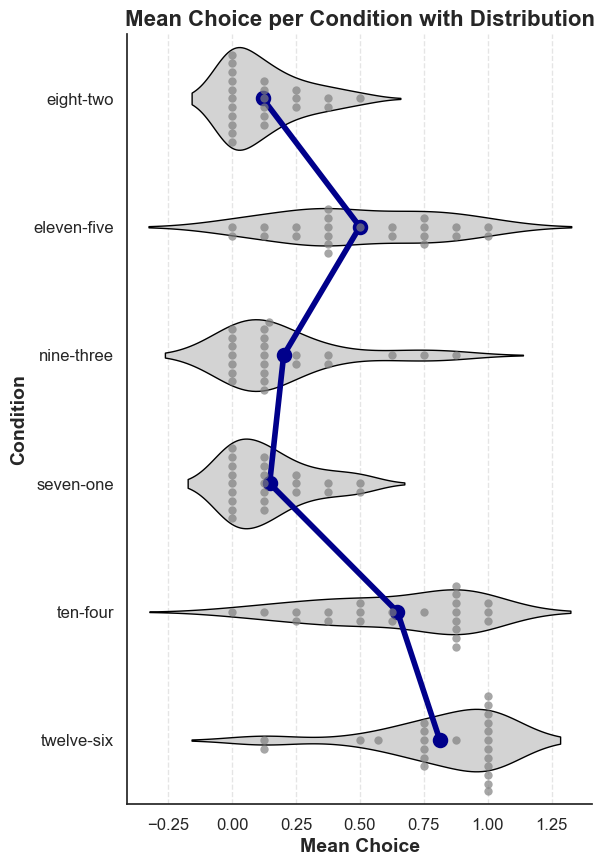

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the correct order for the conditions based on the dataframe (ascending order)
condition_order = sorted(tidy_df['condition'].unique(), key=lambda x: [int(s) if s.isdigit() else s for s in x.split('-')])

# Create the figure
plt.figure(figsize=(6, 10))

# Violinplot to show data distribution (flipped axes)
sns.violinplot(data=mean_choice_by_subject_condition, 
               y='condition', 
               x='mean_choice_by_condition', 
               order=condition_order, 
               inner=None, 
               color='lightgray', 
               linewidth=1)

# Swarmplot to show individual data points (flipped axes)
sns.swarmplot(data=mean_choice_by_subject_condition, 
              y='condition', 
              x='mean_choice_by_condition', 
              order=condition_order, 
              color='gray', 
              size=6, 
              alpha=0.7)

# Pointplot for mean values with a neutral color scheme (flipped axes)
sns.pointplot(data=mean_choice_by_subject_condition, 
              y='condition', 
              x='mean_choice_by_condition', 
              order=condition_order, 
              estimator='mean', 
              ci=None, 
              color='darkblue', 
              markers='o', 
              scale=1.5, 
              linewidth=1.5)

# Manuelles Anpassen der Marker-Ränder
for artist in plt.gca().collections:
    artist.set_edgecolor('black')

# Customize the plot for scientific presentation
plt.ylabel('Condition', fontsize=14, fontweight='bold')
plt.xlabel('Mean Choice', fontsize=14, fontweight='bold')
plt.title('Mean Choice per Condition with Distribution', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine()

# Show the plot
plt.show()
